"I/we certify that the code and data in this assignment were generated independently, using only the tools and resources defined in the course and that I/we did not receive any external help, coaching or contributions during the production of this work."



> Implementing Double DQN on cartpole environment



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import tensorflow as tf
import random, math, time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import matplotlib
import tensorflow.keras.backend as K

In [2]:
cart_pole_env = gym.make('CartPole-v1')

In [3]:
print(cart_pole_env.observation_space)
print(cart_pole_env.action_space)

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Discrete(2)


Below is the replay buffer class

In [4]:
class ReplayBuffer(object):

    def __init__(self, size):
      self.size = size
      self.buffer = []
      self.idx = 0

    def add(self,state,action,reward,newstate,done):
      if len(self.buffer) >= self.size:
        self.buffer[self.idx] = (state,action,reward,newstate,done)
      else:
          self.buffer.append((state,action,reward,newstate,done))

      self.idx+=1

      if self.idx == self.size:
        self.idx = 0

    def sample(self, batch_size):
      size_sample = min(len(self.buffer), batch_size)
      return random.sample(self.buffer, size_sample)
      

In [5]:
class Agent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, observation):
    return np.random.choice(self.action_space.n)

Below is the NN initialization, training class

> Indented block



In [7]:
class DQLearning:
    def __init__(self,env,agent):
        self.env = env
        self.agent = agent
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.Depsilon_decay = []
        self.dqn_reward_train = []
        self.Dlosses= []
        self.average_reward = [0]*10
        
    def greedy_act_max(self,obs):
        return np.argmax(self.model_target(obs))
        
    def policy(self,epsilon,obs):
        return random.choices([np.random.randint(self.action_space.n), self.greedy_act_max(obs)], weights =(epsilon,1-epsilon),k=1)[0]
    
    def max_Qval(self,state):
        return np.argmax(self.target_qtable, axis=1)[state]

    def learning_network_model(self,lr,input_state_dim,output_action_dim):
        model = Sequential()
        model.add(Dense(32, input_dim=input_state_dim, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(output_action_dim, activation='linear'))
        opt = tf.keras.optimizers.Adam(learning_rate=lr)      #adam 
        model.compile(loss='mse', optimizer=opt)
        return model
        

        # replay memory size of 2000, minibatch size =256
        #epoch could try 3
    def train(self,episodes,gamma,alfa_lr,decay_factor,replay_buffer_size=2000,minibatch_size=200):
        epsilon = 1
        episodes = episodes
        rbuffer = ReplayBuffer(replay_buffer_size)
        obs = self.env.reset()
        obs_size = 4
        action_size = self.env.action_space.n
        self.model_policy = self.learning_network_model(alfa_lr,obs_size,action_size)
        self.model_target = self.learning_network_model(alfa_lr,obs_size,action_size)
        self.model_target.set_weights(self.model_policy.get_weights())
        average_idx = 0
       
        for eps_n in np.arange(episodes):
            obs = self.env.reset()
            done_iter = False
            self.Depsilon_decay.append(epsilon)
            print("The episode no. is " + str(eps_n))
            cumm_reward=0
            step_no=0

            while not done_iter:
              action = int(self.policy(epsilon,obs.reshape(1,obs_size)))
              obs_next, reward, done_iter, info = self.env.step(action)
              cumm_reward += reward

              rbuffer.add(obs.reshape(1,obs_size),action,reward,obs_next.reshape(1,obs_size),done_iter)
              step_no+=1
              obs = obs_next
              
              batch = rbuffer.sample(minibatch_size)
              batch_size = len(batch)
              if batch_size == minibatch_size:
                if step_no%5==0:
                  state_next = tf.stack([s2 for (s1,a,r,s2,d) in batch])
                  curr_state = tf.stack([s1 for (s1,a,r,s2,d) in batch])
                  action_ = tf.stack([a for (s1,a,r,s2,d) in batch])
                  reward_ = tf.cast(tf.stack([r for (s1,a,r,s2,d) in batch]), tf.float32)
                  done_ = tf.cast(tf.stack([d for (s1,a,r,s2,d) in batch]), tf.float32)
                  if True:
                    next_q = self.model_target.predict(tf.reshape(state_next,(minibatch_size,obs_size)))
                    #print("7")
                    max_q = tf.math.reduce_max(next_q, axis=1, keepdims=False)
                    #print("9")
                    target_y = reward_  + gamma*(1-done_)*max_q
                    #print("10")
                  #print("12")
                  x = tf.reshape(curr_state,(minibatch_size,obs_size))
                  #print("13")
                  q_predicted = self.model_policy.predict(tf.reshape(curr_state,(minibatch_size,obs_size)))
                  dept_action = tf.expand_dims(action_, 1)    #adding depth dimension to the action tensor
                  #print("14", b_2)
                  index_tensor = tf.expand_dims(tf.range(tf.shape(action_)[0]), 1)   #adding depth dimension to a new tensor with shape as action tensor
                  #print("15", range)
                  index_to_update = tf.concat([index_tensor, dept_action], 1)        #adding depth dimension to a new tensor with shape as action tensor
                  #print("16")
                  y = tf.tensor_scatter_nd_update(q_predicted, index_to_update, target_y)
                  #print("14")
                  sequential_model = self.model_policy.fit(x, y, batch_size=minibatch_size, epochs=1, verbose=0)
                  self.Dlosses.append(sequential_model.history['loss'])
                  #print("16")
            
            if epsilon > 0.001 : epsilon = epsilon*decay_factor
            self.dqn_reward_train.append(cumm_reward)
            average_idx = 0 if average_idx == 9 else 1 + average_idx
            self.average_reward[average_idx] = cumm_reward
            avg_reward = int(sum(self.average_reward)/len(self.average_reward))
            if avg_reward >470: 
              break 
              print("average reward for the last consecutive episodes is "+ avg_reward +"greater than 470")
            print("cummulative reward is " + str(cumm_reward) + " for episode no. " + str(eps_n + 1)  )  

            #every c steps set your target weights to the model policy weights
            if eps_n%5==0:
              self.model_target.set_weights(self.model_policy.get_weights())

            
            

In [8]:

agent = Agent(cart_pole_env)

epsilon = 1
number_of_episodes = 1000
decay_factor = round((0.01/epsilon)**(1/number_of_episodes),4)

dql = DQLearning(cart_pole_env,agent)

In [9]:
dql.train(episodes = number_of_episodes,gamma = 0.99, alfa_lr = 0.001, decay_factor=decay_factor)

The episode no. is 0
cummulative reward is 24.0 for episode no. 1
The episode no. is 1
cummulative reward is 22.0 for episode no. 2
The episode no. is 2
cummulative reward is 15.0 for episode no. 3
The episode no. is 3
cummulative reward is 12.0 for episode no. 4
The episode no. is 4
cummulative reward is 38.0 for episode no. 5
The episode no. is 5
cummulative reward is 19.0 for episode no. 6
The episode no. is 6
cummulative reward is 20.0 for episode no. 7
The episode no. is 7
cummulative reward is 30.0 for episode no. 8
The episode no. is 8
cummulative reward is 14.0 for episode no. 9
The episode no. is 9
cummulative reward is 14.0 for episode no. 10
The episode no. is 10
cummulative reward is 16.0 for episode no. 11
The episode no. is 11
cummulative reward is 22.0 for episode no. 12
The episode no. is 12
cummulative reward is 85.0 for episode no. 13
The episode no. is 13
cummulative reward is 25.0 for episode no. 14
The episode no. is 14
cummulative reward is 18.0 for episode no. 15

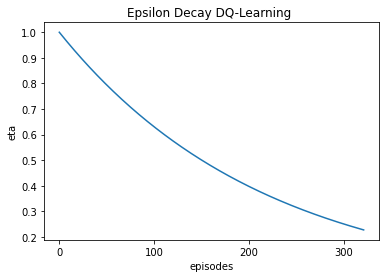

In [11]:
#Plotting Epsilon Decay DQ-Learning 
plt.plot(dql.Depsilon_decay,mfc='pink') 
plt.xticks(range(0,len(dql.Depsilon_decay)+1, 100)) 

plt.ylabel('eta')
plt.xlabel('episodes') 
plt.title("Epsilon Decay DQ-Learning ") 
plt.show()

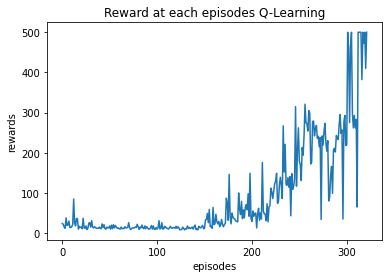

In [12]:
#Reward at each iteration DQ-Learning
plt.plot(dql.dqn_reward_train) 
plt.xticks(range(0,len(dql.dqn_reward_train)+1, 100)) 

plt.ylabel('rewards')
plt.xlabel('episodes') 
plt.title("Reward at each episodes Q-Learning") 
plt.show()

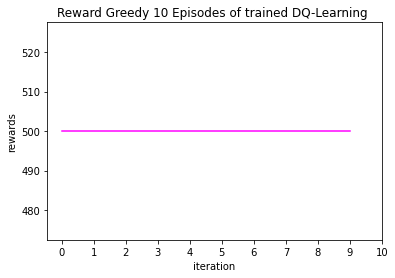

In [13]:
#evaluate Q learning
gamma = 0.95

reward_DQlearning_10ep = []
for i in np.arange(10):
    obs = dql.env.reset()
    done_iter = False
    print(i,end="\r")
    cumm_reward=0
    step_no = 0
    while not done_iter:
        action = int(dql.greedy_act_max(obs.reshape(1,4)))
        obs_next, reward, done_iter, info = dql.env.step(action)
        cumm_reward += reward
        obs = obs_next
        # done_iter = done
        step_no += 1
    reward_DQlearning_10ep.append(cumm_reward)

plt.plot(reward_DQlearning_10ep,color='magenta') 
plt.xticks(range(0,len(reward_DQlearning_10ep)+1, 1)) 

plt.ylabel('rewards')
plt.xlabel('iteration') 
plt.title("Reward Greedy 10 Episodes of trained DQ-Learning ") 
plt.show()

Below code is for the implementation of Double DQN on the cartpole environment

In [57]:
class DDQLearning:
    def __init__(self,env,agent):
        self.env = env
        self.agent = agent
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.DDepsilon_decay = []
        self.ddqn_reward_train = []
        self.DDlosses = []
        self.average_reward = [0]*10
        
    def greedy_act_max(self,obs):
        return np.argmax(self.model_target(obs))
        
    def policy(self,epsilon,obs):
        return random.choices([np.random.randint(self.action_space.n), self.greedy_act_max(obs)], weights =(epsilon,1-epsilon),k=1)[0]
    
    def max_Qval(self,state):
        return np.argmax(self.target_qtable, axis=1)[state]

    def learning_network_model(self,lr,input_state_dim,output_action_dim):
        model = Sequential()
        model.add(Dense(32, input_dim=input_state_dim, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(output_action_dim, activation='linear'))
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(loss='mse', optimizer=opt)
        return model
        
    def train(self,episodes,gamma,alfa_lr,decay_factor,replay_buffer_size=3000,minibatch_size=256):
        epsilon = 1
        episodes = episodes
        rbuffer = ReplayBuffer(replay_buffer_size)
        obs = self.env.reset()
        obs_size = 4
        action_size = self.env.action_space.n
        self.model_policy = self.learning_network_model(alfa_lr,obs_size,action_size)
        self.model_target = self.learning_network_model(alfa_lr,obs_size,action_size)
        self.model_target.set_weights(self.model_policy.get_weights())
        average_idx = 0
       
        for eps_n in np.arange(episodes):
            obs = self.env.reset()
            done_iter = False
            self.DDepsilon_decay.append(epsilon)
            print("The episode no. is " + str(eps_n))
            cumm_reward=0
            step_no=0

            while not done_iter:
              action = int(self.policy(epsilon,obs.reshape(1,obs_size)))
              obs_next, reward, done_iter, info = self.env.step(action)
              cumm_reward += reward

              rbuffer.add(obs.reshape(1,obs_size),action,reward,obs_next.reshape(1,obs_size), done_iter)
              step_no+=1
              obs = obs_next
              
              batch = rbuffer.sample(minibatch_size)
              batch_size = len(batch)
              if batch_size == minibatch_size:
                curr_pos_batch = np.array([ sample_state[0] for sample_state in batch ])
                if step_no%5==0:
                  state_next = tf.stack([s2 for (s1,a,r,s2,d) in batch])
                  curr_state = tf.stack([s1 for (s1,a,r,s2,d) in batch])
                  action_ = tf.stack([a for (s1,a,r,s2,d) in batch])
                  reward_ = tf.cast(tf.stack([r for (s1,a,r,s2,d) in batch]), tf.float32)
                  done_ = tf.cast(tf.stack([d for (s1,a,r,s2,d) in batch]), tf.float32)
                  if True:
                    next_q = self.model_policy.predict(tf.reshape(state_next,(minibatch_size,obs_size)))
                    #print("7")
                    max_a = tf.math.argmax(next_q, 1)
                    #print("8")
                    double_q = self.model_target.predict(tf.reshape(state_next,(minibatch_size,obs_size)))
                    #print("9")
                    target_y = reward_  + gamma*(1-done_)*(tf.gather(double_q[0], max_a).numpy())
                    #print("10")
 
                  #print("11")
                  #print("12")
                  x = tf.reshape(curr_state,(minibatch_size,obs_size))
                  #print("13")
                  q_predicted = self.model_policy.predict(tf.reshape(curr_state,(minibatch_size,obs_size)))
                  dept_action = tf.expand_dims(action_, 1)    #adding depth dimension to the action tensor
                  #print("14", b_2)
                  index_tensor = tf.expand_dims(tf.range(tf.shape(action_)[0]), 1)   #adding depth dimension to a new tensor with shape as action tensor
                  #print("15", range)
                  index_to_update = tf.concat([index_tensor, dept_action], 1)        #adding depth dimension to a new tensor with shape as action tensor
                  #print("16")
                  y = tf.tensor_scatter_nd_update(q_predicted, index_to_update, target_y)
                  #print("14")
                  #print(tf.shape(x) ,tf.shape(y))
                  sequential_model = self.model_policy.fit(x, y, batch_size=minibatch_size, epochs=1, verbose=0)
                  self.DDlosses.append(sequential_model.history['loss'])
                  #print("16")

            if epsilon > 0.001 : epsilon = epsilon*decay_factor
            self.ddqn_reward_train.append(cumm_reward)
            average_idx = 0 if average_idx == 9 else 1 + average_idx
            self.average_reward[average_idx] = cumm_reward
            avg_reward = int(sum(self.average_reward)/len(self.average_reward))
            if avg_reward >470: 
              break 
              print("average reward for the last consecutive episodes is "+ avg_reward +"greater than 470")
            print("cummulative reward is " + str(cumm_reward) + " for episode no. " + str(eps_n + 1)  )  

            #every c steps set your target weights to the model policy weights
            if eps_n%2==0:
              self.model_target.set_weights(self.model_policy.get_weights())
            
            

In [58]:
agent = Agent(cart_pole_env)

epsilon = 1
number_of_episodes = 1000
decay_factor = round((0.01/epsilon)**(1/number_of_episodes),4)

ddql = DDQLearning(cart_pole_env,agent)

In [59]:
ddql.train(episodes = number_of_episodes,gamma = 0.99, alfa_lr = 0.001, decay_factor=decay_factor)

The episode no. is 0
cummulative reward is 20.0 for episode no. 1
The episode no. is 1
cummulative reward is 19.0 for episode no. 2
The episode no. is 2
cummulative reward is 10.0 for episode no. 3
The episode no. is 3
cummulative reward is 17.0 for episode no. 4
The episode no. is 4
cummulative reward is 21.0 for episode no. 5
The episode no. is 5
cummulative reward is 16.0 for episode no. 6
The episode no. is 6
cummulative reward is 9.0 for episode no. 7
The episode no. is 7
cummulative reward is 11.0 for episode no. 8
The episode no. is 8
cummulative reward is 32.0 for episode no. 9
The episode no. is 9
cummulative reward is 20.0 for episode no. 10
The episode no. is 10
cummulative reward is 19.0 for episode no. 11
The episode no. is 11
cummulative reward is 13.0 for episode no. 12
The episode no. is 12
cummulative reward is 10.0 for episode no. 13
The episode no. is 13
cummulative reward is 16.0 for episode no. 14
The episode no. is 14
cummulative reward is 12.0 for episode no. 15


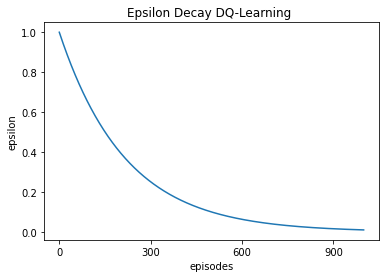

In [60]:
#Plotting Epsilon Decay DQ-Learning 
plt.plot(ddql.DDepsilon_decay,mfc='pink') 
plt.xticks(range(0,len(ddql.DDepsilon_decay)+1, 300)) 

plt.ylabel('epsilon')
plt.xlabel('episodes') 
plt.title("Epsilon Decay DQ-Learning ") 
plt.show()

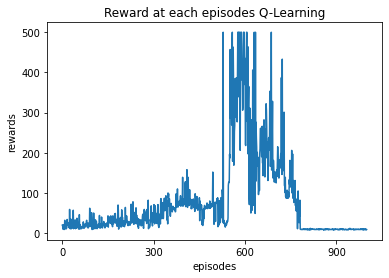

In [61]:
#Reward at each iteration DQ-Learning
plt.plot(ddql.ddqn_reward_train) 
plt.xticks(range(0,len(ddql.ddqn_reward_train)+1, 300)) 

plt.ylabel('rewards')
plt.xlabel('episodes') 
plt.title("Reward at each episodes Q-Learning") 
plt.show()

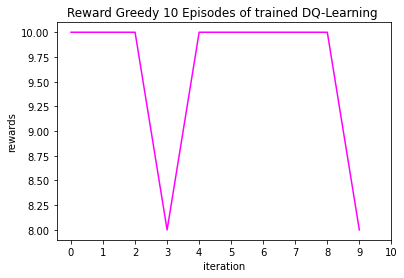

In [62]:
#evaluate Q learning
gamma = 0.95

reward_DQlearning_10ep = []
for i in np.arange(10):
    obs = ddql.env.reset()
    done_iter = False
    print(i,end="\r")
    cumm_reward=0
    step_no = 0
    while not done_iter:
        action = int(ddql.greedy_act_max(obs.reshape(1,4)))
        obs_next, reward, done_iter, info = ddql.env.step(action)
        cumm_reward += reward
        obs = obs_next
        # done_iter = done
        step_no += 1
    reward_DQlearning_10ep.append(cumm_reward)

plt.plot(reward_DQlearning_10ep,color='magenta') 
plt.xticks(range(0,len(reward_DQlearning_10ep)+1, 1)) 

plt.ylabel('rewards')
plt.xlabel('iteration') 
plt.title("Reward Greedy 10 Episodes of trained DQ-Learning ") 
plt.show()

Comparison of reward dynamics for application of DQN and Double DQN on cart pole v1

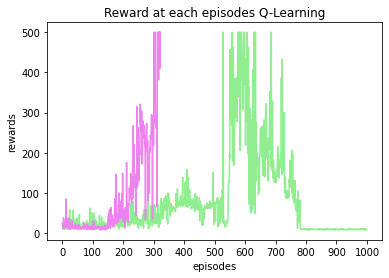

In [63]:
#Reward at each iteration DQ-Learning
plt.plot(ddql.ddqn_reward_train ,color='lightgreen') 
plt.plot(dql.dqn_reward_train,color='violet') 
plt.xticks(range(0,len(ddql.ddqn_reward_train)+1, 100)) 

plt.ylabel('rewards')
plt.xlabel('episodes') 
plt.title("Reward at each episodes Q-Learning") 
plt.show()